In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
import itertools
import json

In [3]:
df = pd.read_csv('../data/data_preprocess_2_attempt.tsv', sep='\t')


# Устраняем мультиколлинеарность

In [4]:
def perfectly_correlated_columns(df):
    corr = df.corr().abs()
    pairs = [(i, j) for i in corr.columns for j in corr.columns if i != j and corr.loc[i, j] == 1]
    return pd.DataFrame(pairs, columns=["col1", "col2"]).drop_duplicates()

perfectly_correlated_columns(df)

,col1,col2


In [5]:
def drop_perfectly_correlated(df):
    corr = df.corr().abs()
    to_drop = set()
    for col in corr.columns:
        for other in corr.columns:
            if col != other and corr.loc[col, other] == 1:
                to_drop.add(other)
    return df.drop(columns=list(to_drop))

df = drop_perfectly_correlated(df)
df = df.loc[:, df.nunique() != 1]

In [6]:
df.head(3)

,price_rub,weight_g,kcal_per_100g,proteins_g_per_100g,fats_g_per_100g,carbs_g_per_100g,shelf_life_days,storage_temp_min_c,storage_temp_max_c,Россия,...,ТПК НВН,"ООО ""ПРО ВКУС","ООО ""МИРЛИС","ООО ""СТУДИЯ ВКУСА","ООО ""КРОХА","ООО ""ВКУСТЕХ","ООО ""ПЕЧКА ВЫПЕЧКА","ООО ""ПРОМЫШЛЕННАЯ КУЛИНАРИЯ",Other Manifactures,score
0,-0.051095,-0.135,0.316251,-1.064516,0.891263,0.163035,0.0,0.431373,0.25,1,...,0,0,1,0,0,0,0,0,0,-1
1,-0.489051,1.765,-1.475993,-1.000000,-0.981772,-0.802634,0.0,0.431373,0.25,1,...,0,0,1,0,0,0,0,0,0,1
2,0.313869,0.065,-0.253463,-0.193548,-0.277813,0.169306,0.0,0.431373,0.25,1,...,0,0,0,0,0,0,0,0,0,-1


# Разделение на test/train и удаление константных столбцов

In [7]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df["score"])
print(train_df["score"].sum() / len(train_df))
print(val_df["score"].sum() / len(val_df))

-0.6994818652849741
-0.7010309278350515


In [8]:
constant_columns = [col for col in train_df.columns if train_df[col].nunique() == 1]
print("Константные столбцы:", constant_columns)


Константные столбцы: []


In [9]:
train_df = train_df.drop(columns=constant_columns)
val_df = val_df.drop(columns=constant_columns)

In [10]:
def from_df_to_X_y(df, intercept=True):
    y = df["score"].to_numpy()
    df_without_score = df.drop(columns=["score"])
    X = df_without_score.to_numpy()
    if intercept:
        X = np.column_stack((np.ones((X.shape[0], 1)), X))
    return X, y

In [11]:
X_train, y_train = from_df_to_X_y(train_df)
X_val, y_val = from_df_to_X_y(val_df)

# Создание и обучение моделей

## На основе аналитического решения

In [12]:
def ols_fit(X, y):
    X = np.asarray(X)
    y = np.asarray(y)
    theta = np.linalg.inv(X.T @ X) @ (X.T @ y)
    return theta

def ols_svd_fit(F, y, rcond = 1e-12):
    U, S, Vt = np.linalg.svd(F, full_matrices=False)
    tol = (S.max() if S.size else 0.0) * rcond
    S_inv = np.where(S > tol, 1.0 / S, 0.0)

    F_plus = (Vt.T * S_inv) @ U.T 
    theta = F_plus @ y             
    return theta

def ridge_fit(X, y, tau=0.1):
    X = np.asarray(X)
    y = np.asarray(y)
    m = X.shape[1]
    theta = np.linalg.inv(X.T @ X + tau * np.eye(m)) @ (X.T @ y)
    return theta

def ridge_svd_fit(F, y, tau, rcond = 1e-12):
    U, S, Vt = np.linalg.svd(F, full_matrices=False)
    tol = (S.max() if S.size else 0.0) * rcond
    filt = S / (S * S + tau)
    filt = np.where(S > tol, filt, 0.0)

    F_ridge = (Vt.T * filt) @ U.T
    theta = F_ridge @ y
    return theta


In [13]:
theta_ols_svd = ols_svd_fit(X_train, y_train)
theta_ols = ols_fit(X_train, y_train)
theta_ridge = ridge_fit(X_train, y_train, tau=6)
theta_ridge_svd = ridge_svd_fit(X_train, y_train, tau=6)

thetas = {
    "OLS": theta_ols,
    "OLS_SVD": theta_ols_svd,
    "Ridge": theta_ridge,
    "Ridge_SVD": theta_ridge_svd
}


## С помощью градиентного спуска

### Реализация

In [ ]:
def gd_linear_clf_fit(
    X,
    y,
    loss='svm',
    lr=0.1,
    alpha=0.0,
    l1_ratio=0.0,
    n_iter=1000,
    tol=None,
    plot=False,
    X_val=None,
    y_val=None,
):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float)

    if X_val is not None:
        X_val = np.asarray(X_val, dtype=float)
    if y_val is not None:
        y_val = np.asarray(y_val, dtype=float)

    n, d = X.shape
    theta = np.zeros(d, dtype=float)

    l1 = alpha * l1_ratio
    l2 = alpha * (1.0 - l1_ratio)

    history = []
    val_history = []

    for _ in range(n_iter):
        M = y * (X @ theta)

        if loss == 'svm':
            mask = (M < 1.0).astype(float)
            dL_dM = -mask
            L = np.maximum(0.0, 1.0 - M)
        elif loss == 'logistic':
            eM = np.exp(-np.clip(M, -50.0, 50.0))
            dL_dM = -(eM / (1.0 + eM)) / np.log(2.0)
            L = np.log1p(eM) / np.log(2.0)
        elif loss == 'exponential':
            e = np.exp(-np.clip(M, -50.0, 50.0))
            dL_dM = -e
            L = e
        elif loss == 'square':
            M_clip = np.clip(M, -2.0, 2.0)
            dL_dM = 2.0 * (M_clip - 1.0)
            L = (np.clip(M, -2.0, 2.0) - 1.0) ** 2
        else:
            raise ValueError(f"Unknown loss: {loss}")

        grad_loss = (X.T @ (dL_dM * y)) / n
        grad = grad_loss + l2 * theta + l1 * np.sign(theta)

        obj = L.mean() + 0.5 * l2 * np.dot(theta, theta) + l1 * np.abs(theta).sum()
        history.append(obj)

        if X_val is not None and y_val is not None:
            Mv = y_val * (X_val @ theta)
            if loss == 'svm':
                Lv = np.maximum(0.0, 1.0 - Mv)
            elif loss == 'logistic':
                eMv = np.exp(-np.clip(Mv, -50.0, 50.0))
                Lv = np.log1p(eMv) / np.log(2.0)
            elif loss == 'exponential':
                ev = np.exp(-np.clip(Mv, -50.0, 50.0))
                Lv = ev
            elif loss == 'square':
                Mv_clip = np.clip(Mv, -2.0, 2.0)
                Lv = (np.clip(Mv, -2.0, 2.0) - 1.0) ** 2
            val_obj = Lv.mean() + 0.5 * l2 * np.dot(theta, theta) + l1 * np.abs(theta).sum()
            val_history.append(val_obj)

        theta_new = theta - lr * grad

        if tol is not None and np.linalg.norm(theta_new - theta) <= tol:
            theta = theta_new
            break

        theta = theta_new

    if plot:
        plt.figure()
        plt.plot(history, label="train")
        if len(val_history) > 0:
            plt.plot(val_history, label="val")
        plt.xlabel("iteration")
        plt.ylabel("loss")
        plt.title("learning curve")
        if len(val_history) > 0:
            plt.legend()
        plt.show()

    return theta


def linear_clf_predict(X, theta):
    X = np.asarray(X, dtype=float)
    f = X @ theta
    y_pm1 = np.sign(f)
    y_pm1[y_pm1 == 0] = 1
    return y_pm1.astype(int)


### Пример кривой обучения со сглаженным эмперическим риском

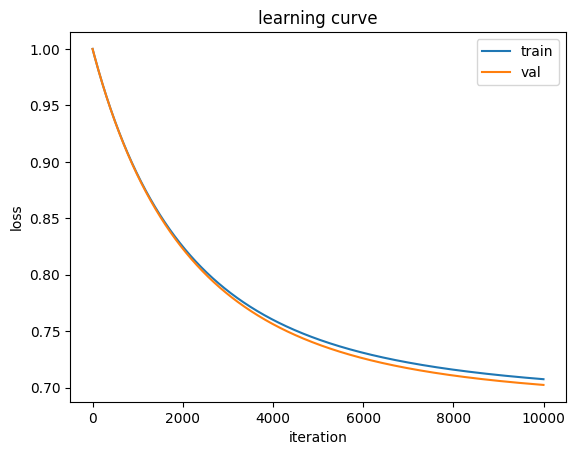

In [101]:
theta = gd_linear_clf_fit(
    X_train, y_train,
    loss='exponential',   
    lr=0.0001,        
    alpha=0.001,      
    l1_ratio=1,    
    n_iter=10000,      
    tol=1e-6,
    plot=True,
    X_val=X_val,
    y_val=y_val,
)


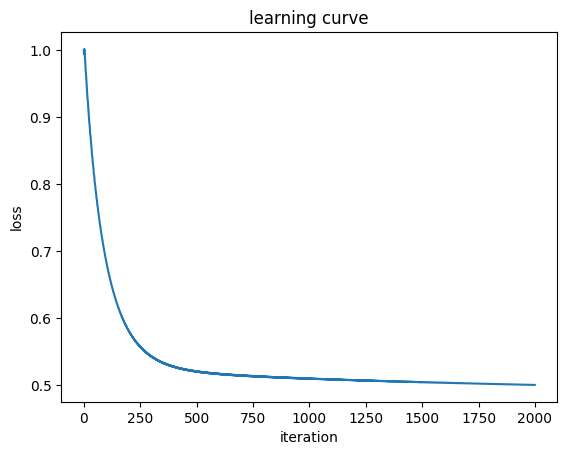

In [72]:
thetas["GD_SVM_l1"] = gd_linear_clf_fit(
    X_train, y_train,
    loss='square',   
    lr=0.001,        
    alpha=0.001,      
    l1_ratio=1,    
    n_iter=2000,      
    tol=1e-6,
    plot=True
)

### Подбираем гиперпараметры

In [73]:
def f_beta(tp, tn, fp, fn, beta=1):
    beta2 = beta * beta
    denom = (beta2 * (tp + fn) + (tp + fp))
    if denom == 0.0:
        return 0
    return (1.0 + beta2) * tp / denom

def f_beta_0_3(tp, tn, fp, fn):
    return f_beta(tp, tn, fp, fn, beta=1.0/3.0)

def _accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

def _precision(tp, tn, fp, fn):
    if tp + fp != 0:
        return tp / (tp + fp)
    return 0

def confusion_from_preds(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int).ravel()
    y_pred = np.asarray(y_pred, dtype=int).ravel()
    tp = int(np.sum((y_true == 1) & (y_pred == 1)))
    tn = int(np.sum((y_true == -1) & (y_pred == -1)))
    fp = int(np.sum((y_true == -1) & (y_pred == 1)))
    fn = int(np.sum((y_true == 1) & (y_pred == -1)))
    return tp, tn, fp, fn

def margin_loss(y_true_pm1, scores, loss='logistic', alpha=0.0, l1_ratio=0.0, theta=None):
    M = y_true_pm1 * scores
    if loss == 'svm':
        L = np.maximum(0.0, 1.0 - M)
    elif loss == 'logistic':
        eM = np.exp(-np.clip(M, -50.0, 50.0))
        L = np.log1p(eM) / np.log(2.0)
    elif loss == 'exponential':
        e = np.exp(-np.clip(M, -50.0, 50.0))
        L = e
    elif loss == 'square':
        M_clip = np.clip(M, -2, 2.0)
        L = (np.clip(M, -2.0, 2.0) - 1.0) ** 2
    else:
        raise ValueError("unknown loss")
    loss_val = L.mean()

    if theta is not None and alpha > 0.0:
        l1 = alpha * l1_ratio
        l2 = alpha * (1.0 - l1_ratio)
        loss_val = loss_val + 0.5 * l2 * np.dot(theta, theta) + l1 * np.abs(theta).sum()

    return loss_val


In [74]:
def grid_search_gd_linear_clf(X_train, y_train, X_val, y_val,
                              loss_list,
                              param_grid_by_loss,
                              metric_fn=None,
                              save_path=None):
    results = {}
    for loss in loss_list:
        grid = param_grid_by_loss[loss]
        keys = list(grid.keys())
        best_score = -np.inf
        best_params = None
        best_theta = None
        for values in itertools.product(*[grid[k] for k in keys]):
            params = dict(zip(keys, values))
            theta = gd_linear_clf_fit(
                X_train, y_train,
                loss=loss,
                lr=params.get("lr", 0.1),
                alpha=params.get("alpha", 0.0),
                l1_ratio=params.get("l1_ratio", 0.0),
                n_iter=params.get("n_iter", 1000),
                tol=params.get("tol", None),
                plot=False
            )
            y_pred = linear_clf_predict(X_val, theta)
            if metric_fn is None:
                y_val_pm1 = np.asarray(y_val, dtype=int).ravel()
                if np.all(np.isin(np.unique(y_val_pm1), [0, 1])):
                    y_val_pm1 = 2 * y_val_pm1 - 1
                score = (y_pred == y_val_pm1).mean()
            else:
                tp, tn, fp, fn = confusion_from_preds(y_val, y_pred)
                score = metric_fn(tp, tn, fp, fn)
            if score > best_score:
                best_score = score
                best_params = params
                best_theta = theta
        results[loss] = {
            "best_score": float(best_score),
            "best_params": best_params,
            "theta": best_theta.tolist()
        }
    if save_path is not None:
        with open(save_path, "w", encoding="utf-8") as f:
            json.dump(results, f, ensure_ascii=False, indent=2)
    return results


In [89]:
param_grid = {
    'svm': {
        'lr': [0.001, 0.003, 0.01],    
        'alpha': [0.05, 0.5, 1, 3],
        'l1_ratio': [0.0, 0.5, 1],        
        'n_iter': [1000],       
        'tol': [None]
    },
    'logistic': {
        'lr': [0.001, 0.003, 0.01],
        'alpha': [0.05, 0.5, 1, 3],
        'l1_ratio': [0.0, 0.5, 1],
        'n_iter': [1000],
        'tol': [None]
    },
    'exponential': {
        'lr': [0.0003, 0.0008, 0.0015], 
        'alpha': [0.05, 0.5, 1, 3],
        'l1_ratio': [0.0, 0.5, 1],
        'n_iter': [1000],
        'tol': [None]
    },
    'square': {
        'lr': [0.0003, 0.0008, 0.0015], 
        'alpha': [0.05, 0.5, 1, 3],
        'l1_ratio': [0.0, 0.5, 1],
        'n_iter': [1000],
        'tol': [None]
    },
}


best = grid_search_gd_linear_clf(X_train, y_train, X_val, y_val, ['svm','logistic','exponential', "square"], param_grid, metric_fn=_accuracy, save_path="best_gd.json")

In [90]:
thetas["Best_SVM"] = best["svm"]["theta"]
thetas["Best_logistic"] = best["logistic"]["theta"]
thetas["Best_exponential"] = best["exponential"]["theta"]
thetas["Best_square"] = best["square"]["theta"]

### Кривая обучения с целевой функцией обучения

In [91]:
def stratified_train_test_split_idx(y, test_size=0.2, rng=None):
    """
    Возвращает два массива индексов: train_idx и test_idx,
    в каждом класс представлен примерно в той же доле, что и в y.
    """
    if rng is None:
        rng = np.random.default_rng()

    y = np.asarray(y)
    classes, y_inv = np.unique(y, return_inverse=True)

    train_idx_parts = []
    test_idx_parts = []

    for c_id in range(len(classes)):
        idx_c = np.where(y_inv == c_id)[0]
        rng.shuffle(idx_c)
        n_test_c = int(np.floor(test_size * len(idx_c)))
        test_idx_parts.append(idx_c[:n_test_c])
        train_idx_parts.append(idx_c[n_test_c:])

    test_idx = np.concatenate(test_idx_parts)
    train_idx = np.concatenate(train_idx_parts)

    rng.shuffle(train_idx)
    rng.shuffle(test_idx)

    return train_idx, test_idx


In [ ]:
def plot_learning_curve_df(
    df,
    y_col="score",
    loss='svm',
    lr=0.01,
    alpha=0.0,
    l1_ratio=0.0,
    n_iter=800,
    eval_every=20,
    n_splits=5,
    test_size=0.2,
    metric_fn=None,
    title="Learning curve",
    mark_linreg=True
):
    X_all = df.drop(columns=[y_col]).to_numpy(dtype=float)
    y_all = df[y_col].to_numpy()

    rng = np.random.default_rng(0)
    all_metrics = []
    common_iters = None

    for split_id in range(n_splits):
        train_idx, test_idx = stratified_train_test_split_idx(
            y_all,
            test_size=test_size,
            rng=rng
        )

        X_train = X_all[train_idx]
        y_train = y_all[train_idx]
        X_test = X_all[test_idx]
        y_test = y_all[test_idx]


        n, d = X_train.shape
        theta = np.zeros(d, dtype=float)
        l1 = alpha * l1_ratio
        l2 = alpha * (1.0 - l1_ratio)

        iters = []
        metrics = []

        for it in range(1, n_iter + 1):
            M = y_train * (X_train @ theta)

            if loss == 'svm':
                mask = (M < 1.0).astype(float)
                dL_dM = -mask
            elif loss == 'logistic':
                eM = np.exp(-np.clip(M, -50.0, 50.0))
                dL_dM = -(eM / (1.0 + eM)) / np.log(2.0)
            elif loss == 'square':
                M_clip = np.clip(M, -2, 2.0)
                dL_dM = 2.0 * (M_clip - 1.0)
            elif loss == 'exponential':
                e = np.exp(-np.clip(M, -50.0, 50.0))
                dL_dM = -e
            else:
                raise ValueError("unknown loss")

            grad_loss = (X_train.T @ (dL_dM * y_train)) / n
            grad = grad_loss + l2 * theta + l1 * np.sign(theta)
            theta = theta - lr * grad

            if it % eval_every == 0 or it == n_iter:
                scores = X_test @ theta
                y_pred = np.where(scores >= 0.0, 1, -1)

                tp = int(np.sum((y_test == 1) & (y_pred == 1)))
                tn = int(np.sum((y_test == -1) & (y_pred == -1)))
                fp = int(np.sum((y_test == -1) & (y_pred == 1)))
                fn = int(np.sum((y_test == 1) & (y_pred == -1)))

                m = metric_fn(tp, tn, fp, fn)
                iters.append(it)
                metrics.append(m)

        iters = np.array(iters)
        metrics = np.array(metrics)

        if common_iters is None:
            common_iters = iters

        all_metrics.append(metrics)

    all_metrics = np.vstack(all_metrics) 
    mean_metric = all_metrics.mean(axis=0)
    std_metric = all_metrics.std(axis=0, ddof=1)
    ci_low = mean_metric - 1.96 * std_metric / np.sqrt(n_splits)
    ci_high = mean_metric + 1.96 * std_metric / np.sqrt(n_splits)

    plt.figure(figsize=(7, 4))

    for i in range(n_splits):
        plt.plot(
            common_iters,
            all_metrics[i],
            color="blue",
            alpha=0.35,
            linewidth=1.3,
            label="split" if i == 0 else None
        )

    plt.plot(common_iters, mean_metric, color="blue", linewidth=2.2, label="mean metric")

    plt.fill_between(common_iters, ci_low, ci_high, alpha=0.15, color="blue", label="95% CI")

    if mark_linreg:
        df_split = df.sample(frac=1.0, random_state=42).reset_index(drop=True)
        y_full = df_split[y_col].to_numpy()
        X_full = df_split.drop(columns=[y_col]).to_numpy(dtype=float)

        n_total = len(y_full)
        n_test = int(np.floor(test_size * n_total))
        X_test_lr = X_full[:n_test]
        y_test_lr = y_full[:n_test]
        X_train_lr = X_full[n_test:]
        y_train_lr = y_full[n_test:]

        theta_lr = np.linalg.pinv(X_train_lr) @ y_train_lr
        scores_lr = X_test_lr @ theta_lr
        y_pred_lr = np.where(scores_lr >= 0.0, 1, -1)

        tp = int(np.sum((y_test_lr == 1) & (y_pred_lr == 1)))
        tn = int(np.sum((y_test_lr == -1) & (y_pred_lr == -1)))
        fp = int(np.sum((y_test_lr == -1) & (y_pred_lr == 1)))
        fn = int(np.sum((y_test_lr == 1) & (y_pred_lr == -1)))
        m_lr = metric_fn(tp, tn, fp, fn)

        plt.axhline(m_lr, color="green", linestyle="--", linewidth=2.0, label="linear regression (test)")

    plt.xlabel("iteration")
    plt.ylabel("metric on holdout")
    plt.title(title)
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()


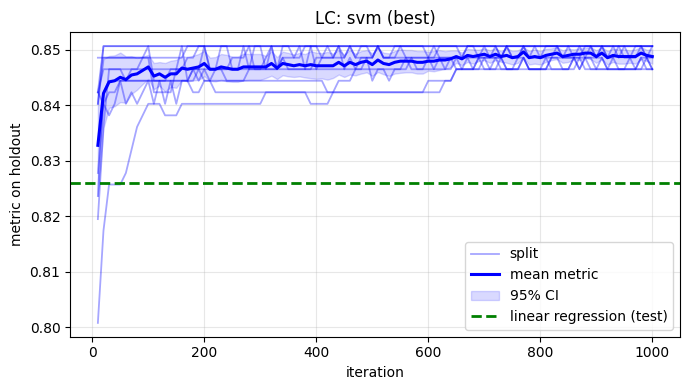

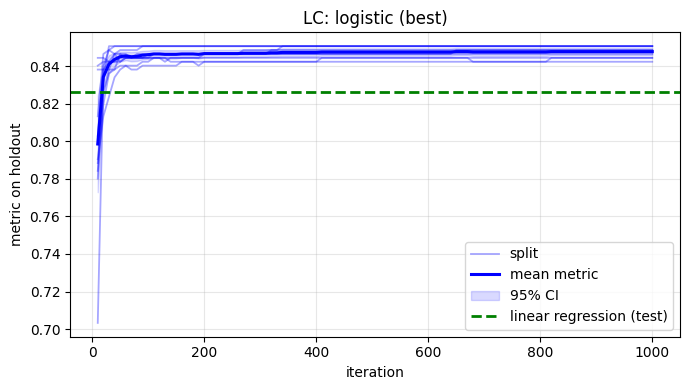

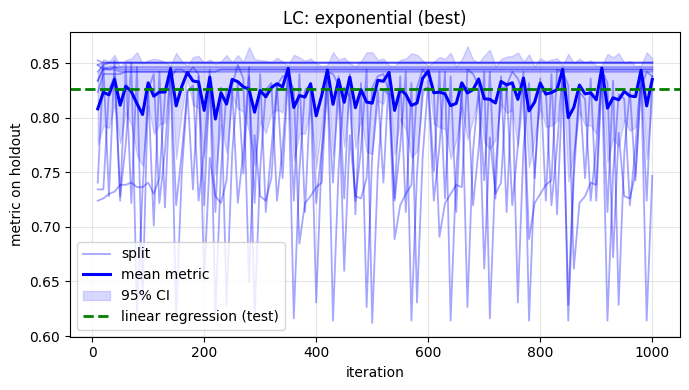

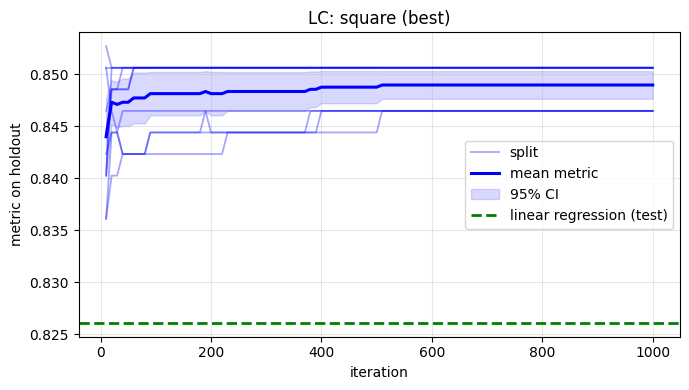

In [93]:
for loss_param in ['svm','logistic','exponential', "square"]:
    params = best[loss_param]["best_params"]
    plot_learning_curve_df(
        df,
        loss=loss_param,
        lr=params["lr"],
        alpha=params["alpha"],
        l1_ratio=params["l1_ratio"],
        n_iter=params["n_iter"],
        eval_every=10,
        n_splits=10,
        test_size=0.5,
        metric_fn=_accuracy,
        title=f"LC: {loss_param} (best)"
    )

### L1 и L2 регуляризация

In [ ]:
def _fit_l2_gd(X, y, loss, lr, alpha, n_iter, tol):
    return gd_linear_clf_fit(
        X,
        y,
        loss=loss,
        lr=lr,
        alpha=alpha,
        l1_ratio=0.0,
        n_iter=n_iter,
        tol=tol,
        plot=False
    )

def _fit_l1_prox(X, y, loss, lr, alpha, n_iter, tol):
    X = np.asarray(X, dtype=float)
    y = np.asarray(y, dtype=float).ravel()
    n, d = X.shape
    theta = np.zeros(d, dtype=float)
    history = []
    for _ in range(n_iter):
        M = y * (X @ theta)
        if loss == 'svm':
            mask = (M < 1.0).astype(float)
            dL_dM = -mask
        elif loss == 'logistic':
            eM = np.exp(-np.clip(M, -50.0, 50.0))
            dL_dM = -(eM / (1.0 + eM)) / np.log(2.0)
        elif loss == 'square':
            M_clip = np.clip(M, -50.0, 50.0)
            dL_dM = 2.0 * (M_clip - 1.0)
        elif loss == 'exponential':
            e = np.exp(-np.clip(M, -50.0, 50.0))
            dL_dM = -e
        else:
            raise ValueError("unknown loss")
        grad_loss = (X.T @ (dL_dM * y)) / n
        theta_tmp = theta - lr * grad_loss
        shrink = lr * alpha
        theta_new = np.sign(theta_tmp) * np.maximum(np.abs(theta_tmp) - shrink, 0.0)
        if tol is not None and np.linalg.norm(theta_new - theta) <= tol:
            theta = theta_new
            break
        theta = theta_new
    return theta

def plot_coeff_paths_df(df,
                        y_col="score",
                        loss='logistic',
                        lr=0.01,
                        n_iter=600,
                        tol=None,
                        l1_min=1e-6,
                        l1_max=1e2,
                        l2_min=1e-6,
                        l2_max=1e2,
                        n_points=40,
                        top_k=10):
    X_all = df.drop(columns=[y_col]).to_numpy(dtype=float)
    y_all = df[y_col].to_numpy(dtype=float)
    if np.all(np.isin(np.unique(y_all), [0.0, 1.0])):
        y_all = 2.0 * y_all - 1.0

    feature_names = df.drop(columns=[y_col]).columns.to_list()
    n_features = X_all.shape[1]

    alphas_l1 = np.logspace(np.log10(l1_min), np.log10(l1_max), n_points)
    alphas_l2 = np.logspace(np.log10(l2_min), np.log10(l2_max), n_points)

    thetas_l1 = []
    for a in alphas_l1:
        theta = _fit_l1_prox(X_all, y_all, loss=loss, lr=lr, alpha=a, n_iter=n_iter, tol=tol)
        thetas_l1.append(theta)
    thetas_l1 = np.vstack(thetas_l1)

    thetas_l2 = []
    for a in alphas_l2:
        theta = _fit_l2_gd(X_all, y_all, loss=loss, lr=lr, alpha=a, n_iter=n_iter, tol=tol)
        thetas_l2.append(theta)
    thetas_l2 = np.vstack(thetas_l2)

    base_theta = thetas_l2[0]
    idx_sorted = np.argsort(np.abs(base_theta))[::-1]
    idx_keep = idx_sorted[:min(top_k, n_features)]

    fig1, ax1 = plt.subplots(figsize=(7, 4))
    for j in idx_keep:
        ax1.plot(alphas_l1, thetas_l1[:, j], label=feature_names[j])
    ax1.set_xscale("log")
    ax1.set_xlabel("alpha (L1)")
    ax1.set_ylabel("coefficient value")
    ax1.set_title("L1 paths (L2 = 0, prox)")
    ax1.grid(True)
    ax1.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(7, 4))
    for j in idx_keep:
        ax2.plot(alphas_l2, thetas_l2[:, j], label=feature_names[j])
    ax2.set_xscale("log")
    ax2.set_xlabel("alpha (L2)")
    ax2.set_ylabel("coefficient value")
    ax2.set_title("L2 paths (L1 = 0)")
    ax2.grid(True)
    ax2.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    plt.show()



C:\Users\zaits\AppData\Local\Temp\ipykernel_4708\620508994.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


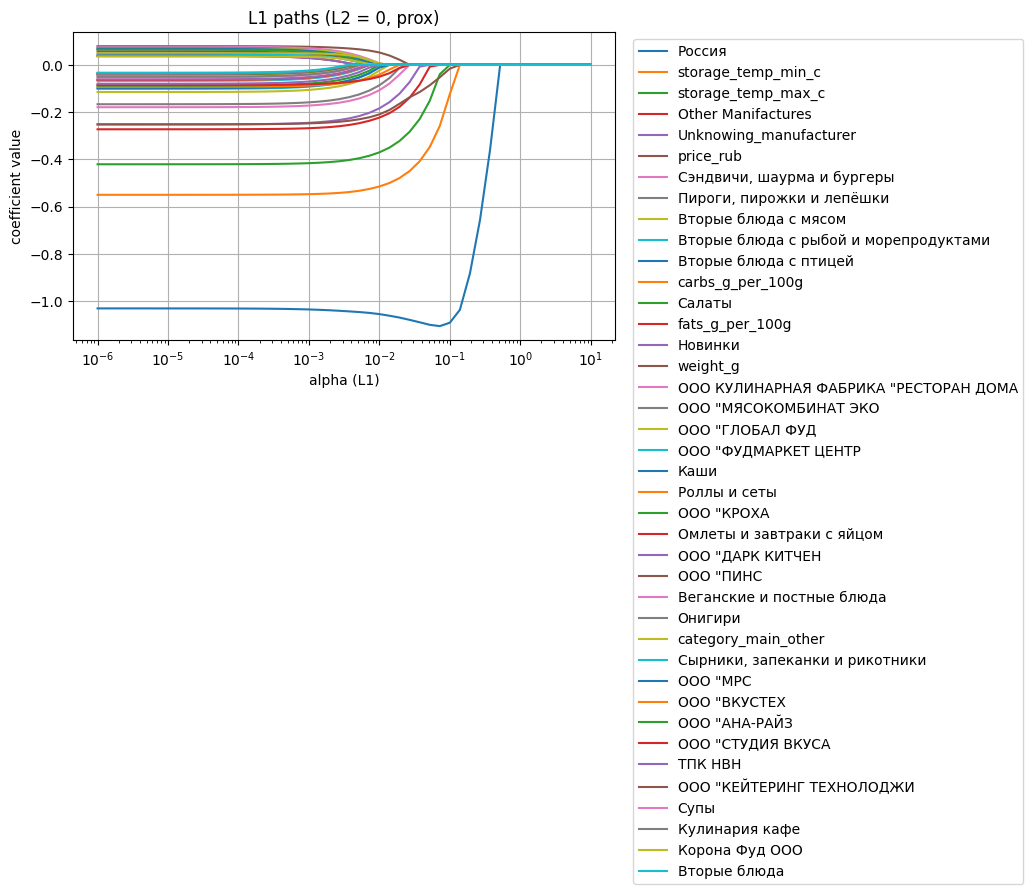

C:\Users\zaits\AppData\Local\Temp\ipykernel_4708\620508994.py:108: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


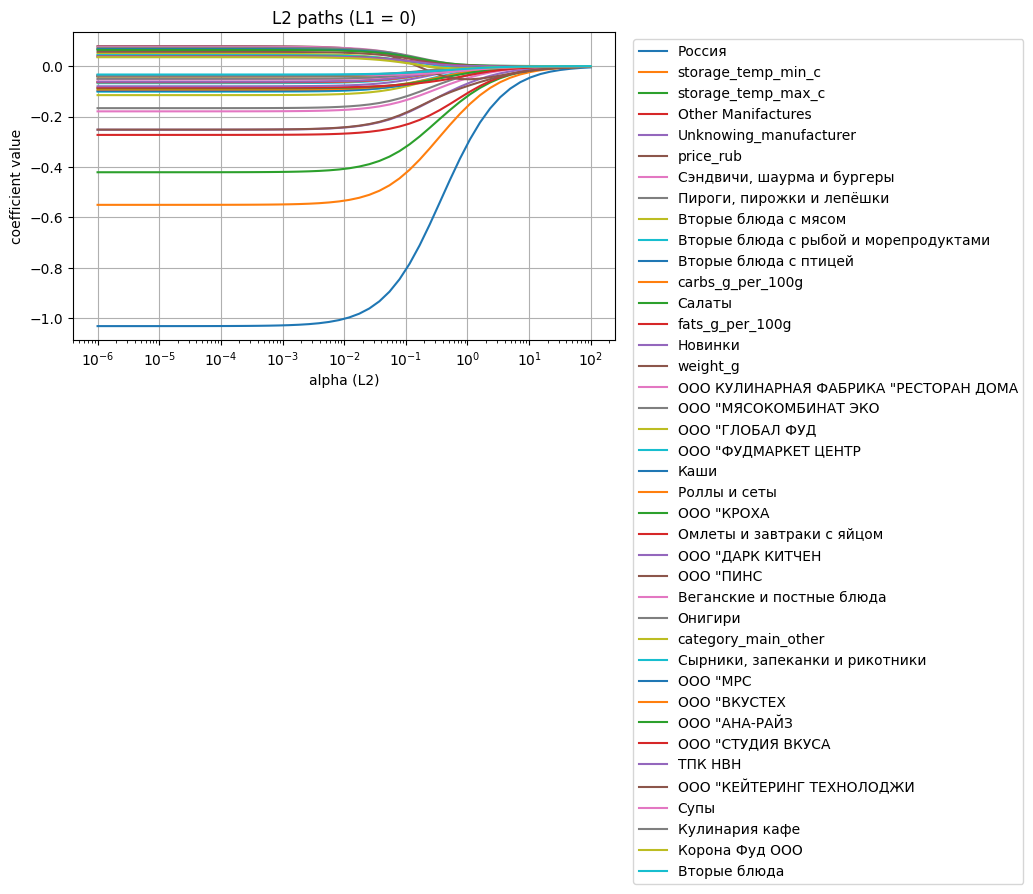

In [32]:
plot_coeff_paths_df(
    df,
    y_col="score",
    loss="logistic",
    lr=0.01,
    n_iter=1000,
    l1_min=1e-6,
    l1_max=10,
    l2_min=1e-6,
    l2_max=100,
    n_points=50,
    top_k=40
)


# Метрики Регрессии

In [38]:
def _predict(X, theta):
    y_pred = X @ theta
    return y_pred

def MSE(X, y, theta):
    y_pred = _predict(X, theta)
    return np.mean((y - y_pred) ** 2)

def RMSE(X, y, theta):
    return np.sqrt(MSE(X, y, theta))

def MAE(X, y, theta):
    y_pred = _predict(X, theta)
    return np.mean(np.abs(y - y_pred))

def MAPE(X, y, theta):
    y_pred = _predict(X, theta)
    return np.mean(np.abs(y - y_pred) / np.abs(y))

def sMAPE(X, y, theta):
    y_pred = _predict(X, theta)
    return np.mean(np.abs(y - y_pred) / ((np.abs(y) + np.abs(y_pred)) / 2))

def R_square(X, y, theta):
    y_pred = _predict(X, theta)
    y_mean = np.mean(y)
    return 1 - np.sum((y - y_pred) ** 2) / np.sum((y - y_mean) ** 2)


## Подбор метрик для 1 случая - Аналитического решения

In [48]:
metrics_reg = [MSE,RMSE, MAE, MAPE, sMAPE, R_square]

results = []
for m in metrics_reg:
    for name_theta, theta in thetas.items():
        result = m(X_val, y_val, theta)
        results.append({
            "Metric": m.__name__,
            "Model": name_theta,
            "Value": result
        })
        
df_results = pd.DataFrame(results)
df_pivot = df_results.pivot(index="Metric", columns="Model", values="Value")
print(df_pivot)

Model     Best_SVM  Best_exponential  Best_logistic  GD_SVM_l1          OLS  \
Metric                                                                        
MAE       0.997611      2.105599e+19       0.995280   0.374830    33.816625   
MAPE      0.997611      2.105599e+19       0.995280   0.374830    33.816625   
MSE       0.995261      9.495393e+38       0.991683   0.636170  1652.984328   
RMSE      0.997627      3.081460e+19       0.995833   0.797603    40.656910   
R_square -0.957034     -1.867130e+39      -0.949998  -0.250936 -3249.351002   
sMAPE     1.988427      2.000000e+00       1.962331   0.363392     1.849142   

Model      OLS_SVD     Ridge  Ridge_SVD  
Metric                                   
MAE       0.438231  0.447583   0.447583  
MAPE      0.438231  0.447583   0.447583  
MSE       0.448979  0.442426   0.442426  
RMSE      0.670059  0.665151   0.665151  
R_square  0.117149  0.130033   0.130033  
sMAPE     0.573089  0.582809   0.582809  


In [49]:
metrics_mse = []
metrics_R_square = []
max_x = 10
obser = 100
count_measures = max_x * obser

for i in range(count_measures):
    tau = i / obser
    theta_tau_ridge = ridge_fit(X_train, y_train, tau=tau)
    metrics_mse.append(MSE(X_val, y_val,theta_tau_ridge))
    metrics_R_square.append(R_square(X_val, y_val,theta_tau_ridge))

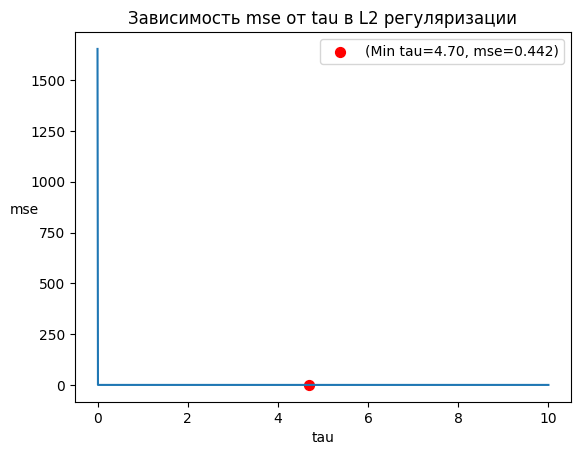

In [50]:
def corr_metric_tau(metrics_mse, obser, count_measures, strategy="max", target="MSE", draw=True):
    if strategy == "min":    
        x_opt = np.argmin(metrics_mse) / obser
        y_opt = np.min(metrics_mse)
    elif strategy == "max":
        x_opt = np.argmax(metrics_R_square) / obser
        y_opt = np.max(metrics_R_square)
    
    if draw:
        x = np.linspace(0, max_x, count_measures)
        plt.plot(x, metrics_mse)
        plt.scatter(x_opt, y_opt, color='red', s=50, label=f"({strategy.capitalize()} tau={x_opt:.2f}, {target}={y_opt:.3f})")
        plt.xlabel("tau")
        plt.ylabel(f"{target}", rotation=0)
        plt.title(f"Зависимость {target} от tau в L2 регуляризации")
        plt.legend()
        
    return x_opt

tau_opt = corr_metric_tau(metrics_mse, obser, count_measures, strategy="min", target="mse")

np.float64(4.7)

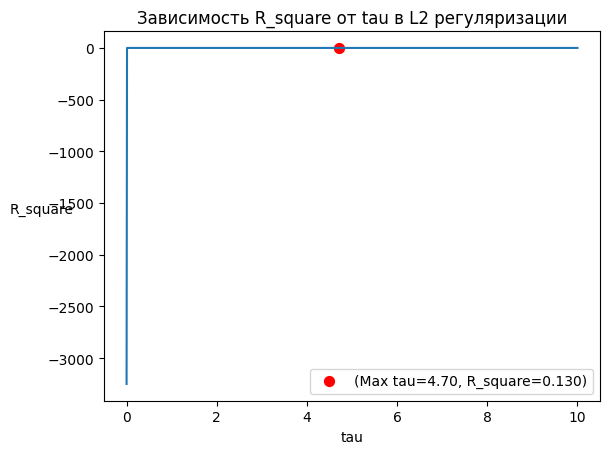

In [51]:
corr_metric_tau(metrics_R_square, obser, count_measures, strategy="max", target="R_square")

In [52]:
metrics_mse = []
metrics_R_square = []
max_x = 300
obser = 1
count_measures = max_x * obser

for i in range(count_measures):
    tau = i / obser
    theta_tau_ridge = ridge_fit(X_train, y_train, tau=tau)
    metrics_mse.append(MSE(X_val, y_val,theta_tau_ridge))
    metrics_R_square.append(R_square(X_val, y_val,theta_tau_ridge))

np.float64(5.0)

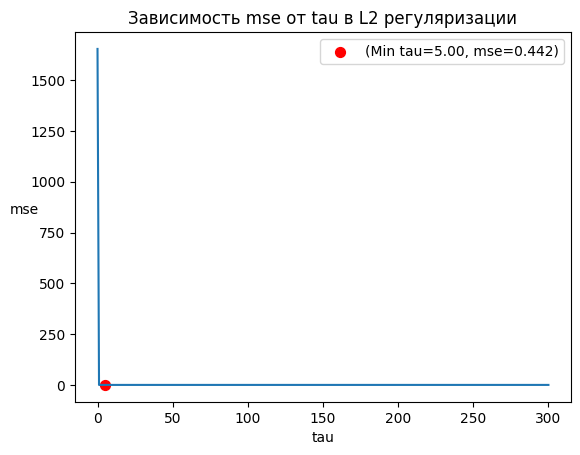

In [53]:
corr_metric_tau(metrics_mse, obser, count_measures, strategy="min", target="mse")

np.float64(5.0)

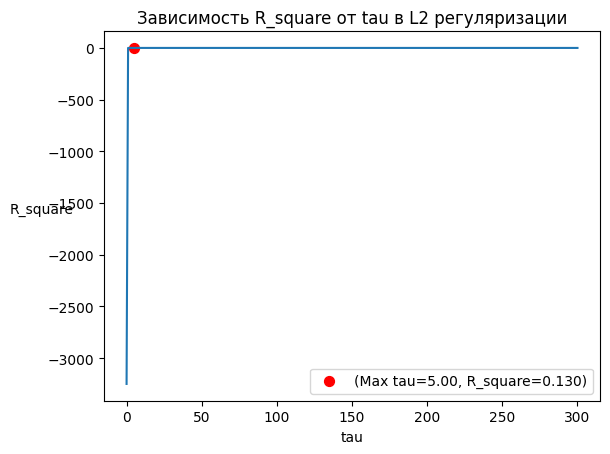

In [54]:
corr_metric_tau(metrics_R_square, obser, count_measures, strategy="max", target="R_square")

# Метрики классификации

In [39]:
def accuracy(tp, tn, fp, fn):
    return (tp + tn) / (tp + tn + fp + fn)

def precision(tp, tn, fp, fn):
    if tp + fp != 0:
        return tp / (tp + fp)
    return 0

def recall(tp, tn, fp, fn):
    return tp / (tp + fn)

def TPR(tp, tn, fp, fn):
    return recall(tp, tn, fp, fn)

def FPR(tp, tn, fp, fn):
    return fp / (fp + tn)

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def log_loss_pm1(y_true, y_pred, eps=1e-15):
    p_pred = sigmoid(y_pred)
    p_pred = np.clip(p_pred, eps, 1 - eps)
    return -np.mean((1 + y_true)/2 * np.log(p_pred) + (1 - y_true)/2 * np.log(1 - p_pred))

metrics_class = [accuracy ,precision, recall, f_beta,f_beta_0_3, TPR, FPR]

In [40]:
def values_by_trashhold(y_pred, y_val, trash_hold=0):
    tp = 0
    tn = 0
    fp = 0
    fn = 0

    idx_sort = (np.argsort(y_pred))
    y_pred_sort = (np.sort(y_pred))

    for i, elem_pred in enumerate(y_pred_sort):
        elem = y_val[idx_sort[i]]
        if elem == -1:
            if elem_pred < trash_hold:
                tn += 1
            else:
                fp += 1
        if elem == 1:
            if elem_pred > trash_hold:
                tp += 1
            else:
                fn += 1

    return tp, tn, fp, fn

In [41]:
def classification_metrics(y_val):
    results = []
    for m in metrics_class:
        for name_theta, theta in thetas.items():
            y_pred = np.array(_predict(X_val, theta))
            y_val = np.array(y_val)
            tp, tn, fp, fn = values_by_trashhold(y_pred, y_val, 0)
            
            result = m(tp, tn, fp, fn)
            results.append({
                "Metric": m.__name__,
                "Model": name_theta,
                "Value": result
            })
            
    df_results_class = pd.DataFrame(results)
    df_pivot_class = df_results_class.pivot(index="Metric", columns="Model", values="Value")
    print(df_pivot_class)

In [42]:
classification_metrics(y_val)

Model       Best_SVM  Best_exponential  Best_logistic  GD_SVM_l1       OLS  \
Metric                                                                       
FPR         0.066667          0.018182       0.284848   0.000000  0.072727   
TPR         0.137931          0.172414       0.517241   0.000000  0.000000   
accuracy    0.814433          0.860825       0.685567   0.850515  0.788660   
f_beta      0.181818          0.270270       0.329670   0.000000  0.000000   
f_beta_0_3  0.243902          0.495050       0.255537   0.000000  0.000000   
precision   0.266667          0.625000       0.241935   0.000000  0.000000   
recall      0.137931          0.172414       0.517241   0.000000  0.000000   

Model        OLS_SVD     Ridge  Ridge_SVD  
Metric                                     
FPR         0.006061  0.000000   0.000000  
TPR         0.103448  0.103448   0.103448  
accuracy    0.860825  0.865979   0.865979  
f_beta      0.181818  0.187500   0.187500  
f_beta_0_3  0.461538  0.535714   

In [55]:
tau_opt = corr_metric_tau(metrics_R_square, obser, count_measures, strategy="max", target="R_square", draw=False)
theta_ridge_1 = ridge_fit(X_train, y_train, tau=tau_opt)

y_val = np.array(y_val)
y_pred = np.array(_predict(X_val, theta_ridge_1))
print("LogLoss:", log_loss_pm1(y_val, y_pred))

LogLoss: 0.4800789698630325


# ROC и PR кривая

## Реализация

In [ ]:
def ROC_curve_and_PR_curve(theta, X_val, y_val, ROC_c=True, PR_c=True, title="Title"):
    X_val = np.asarray(X_val, dtype=float)
    theta = np.asarray(theta, dtype=float).ravel()
    y = np.asarray(y_val).ravel()
    if np.all(np.isin(np.unique(y), [0, 1])):
        y = 2 * y - 1
    y = y.astype(int)

    scores = X_val @ theta
    thr = np.r_[np.inf, np.unique(scores)[::-1], -np.inf]

    vals = []
    for t in thr:
        y_hat = np.where(scores >= t, 1, -1)
        tp = int(np.sum((y == 1) & (y_hat == 1)))
        tn = int(np.sum((y == -1) & (y_hat == -1)))
        fp = int(np.sum((y == -1) & (y_hat == 1)))
        fn = int(np.sum((y == 1) & (y_hat == -1)))
        vals.append((tp, tn, fp, fn))

    tp, tn, fp, fn = zip(*vals)
    tp = np.array(tp); tn = np.array(tn); fp = np.array(fp); fn = np.array(fn)

    def tpr(tp, tn, fp, fn):
        d = tp + fn
        return (tp / d) if d else 0.0

    def fpr(tp, tn, fp, fn):
        d = fp + tn
        return (fp / d) if d else 0.0

    def prec(tp, tn, fp, fn):
        d = tp + fp
        return 1.0 if d == 0 else (tp / d)

    def rec(tp, tn, fp, fn):
        d = tp + fn
        return (tp / d) if d else 0.0

    def acc(tp, tn, fp, fn):
        n = tp + tn + fp + fn
        return (tp + tn) / n if n else 0.0

    def fb03(tp, tn, fp, fn):
        beta = 1.0 / 3.0
        b2 = beta * beta
        d = b2 * (tp + fn) + (tp + fp)
        return (1.0 + b2) * tp / d if d else 0.0

    TPR = np.array([tpr(*v) for v in vals])
    FPR = np.array([fpr(*v) for v in vals])
    PREC = np.array([prec(*v) for v in vals])
    RECL = np.array([rec(*v) for v in vals])
    ACC = np.array([acc(*v) for v in vals])
    FB03 = np.array([fb03(*v) for v in vals])

    order_roc = np.argsort(FPR)
    FPR_s = FPR[order_roc]
    TPR_s = TPR[order_roc]
    auc_roc = np.trapz(TPR_s, FPR_s)

    order_pr = np.argsort(RECL)
    RECL_s = RECL[order_pr]
    PREC_s = PREC[order_pr]
    auc_pr = np.trapz(PREC_s, RECL_s)

    t0_idx = int(np.argmin(np.abs(thr)))
    fb_idx = int(np.nanargmax(FB03))
    pr_idx = int(np.nanargmax(PREC))
    ac_idx = int(np.nanargmax(ACC))

    def _fmt_t(x):
        return f"{x:.3g}"

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    fig.suptitle(title, fontsize=16)

    if ROC_c:
        ax1.plot(FPR, TPR)
        ax1.scatter(FPR[t0_idx], TPR[t0_idx], c="red", s=50, label="With t=0")
        ax1.scatter(FPR[fb_idx], TPR[fb_idx], c="green", s=50, label=f"Max: F_beta_1/3 with t={_fmt_t(thr[fb_idx])}")
        ax1.scatter(FPR[pr_idx], TPR[pr_idx], c="blue", s=50, label=f"Max: Precision with t={_fmt_t(thr[pr_idx])}")
        ax1.scatter(FPR[ac_idx], TPR[ac_idx], c="gold", s=30, label=f"Max: Accuracy with t={_fmt_t(thr[ac_idx])}")
        ax1.set_xlim(0, 1)
        ax1.set_ylim(0, 1)
        ax1.set_xlabel("FPR")
        ax1.set_ylabel("TPR")
        ax1.set_title(f"ROC-curve (AUC={auc_roc:.3f})")
        ax1.grid(True)
        ax1.legend()

    if PR_c:
        ax2.plot(RECL, PREC)
        ax2.scatter(RECL[t0_idx], PREC[t0_idx], c="red", s=50, label="With t=0")
        ax2.scatter(RECL[fb_idx], PREC[fb_idx], c="green", s=50, label=f"Max: F_beta_1/3 with t={_fmt_t(thr[fb_idx])}")
        ax2.scatter(RECL[pr_idx], PREC[pr_idx], c="blue", s=50, label=f"Max: Precision with t={_fmt_t(thr[pr_idx])}")
        ax2.set_xlim(0, 1)
        ax2.set_ylim(0, 1)
        ax2.set_xlabel("Recall")
        ax2.set_ylabel("Precision")
        ax2.set_title(f"PR-curve (AUC={auc_pr:.3f})")
        ax2.grid(True)
        ax2.legend()

    plt.tight_layout()
    plt.show()


    

## Используем

C:\Users\zaits\AppData\Local\Temp\ipykernel_4708\3461490701.py:61: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_roc = np.trapz(TPR_s, FPR_s)
C:\Users\zaits\AppData\Local\Temp\ipykernel_4708\3461490701.py:67: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc_pr = np.trapz(PREC_s, RECL_s)


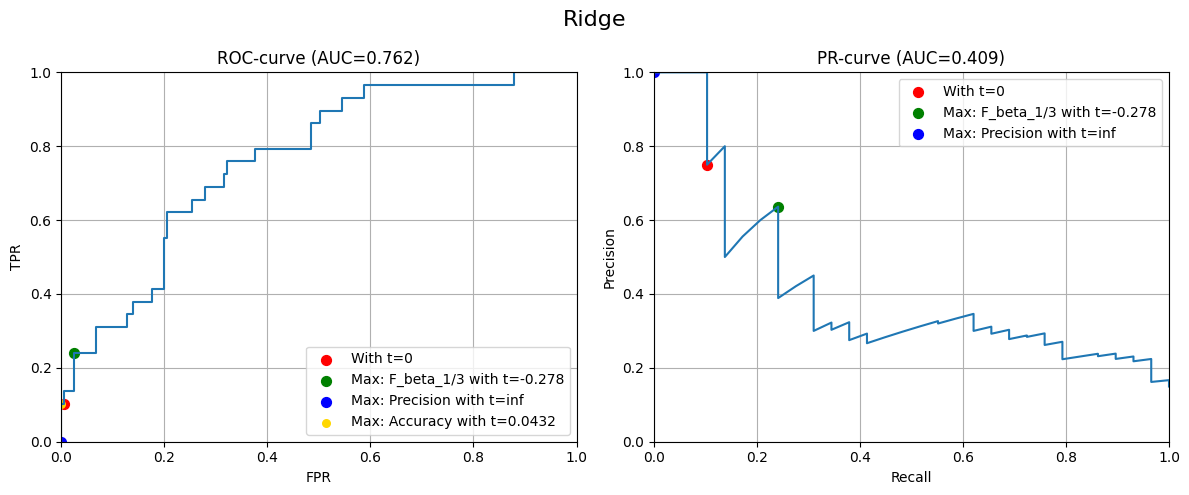

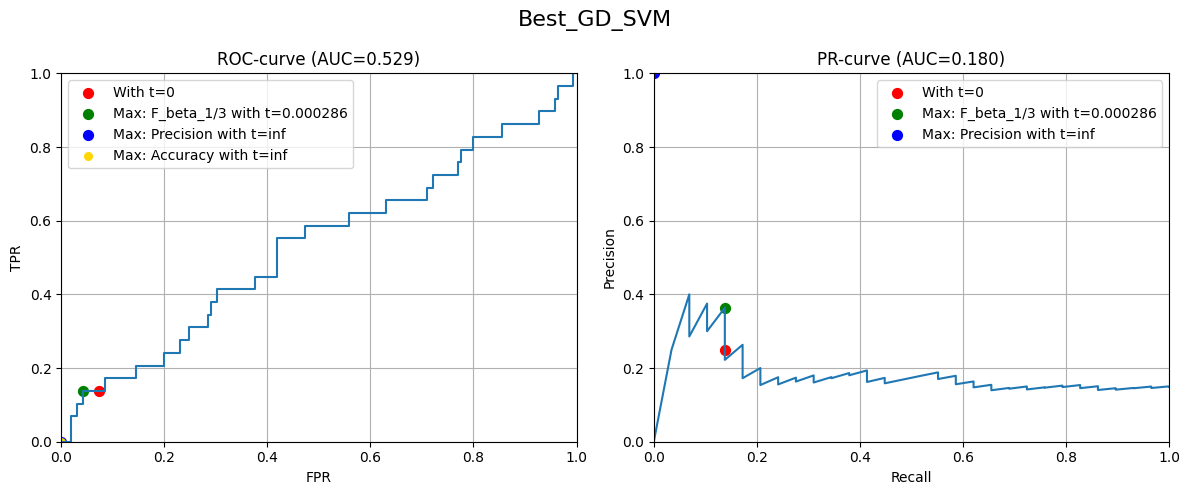

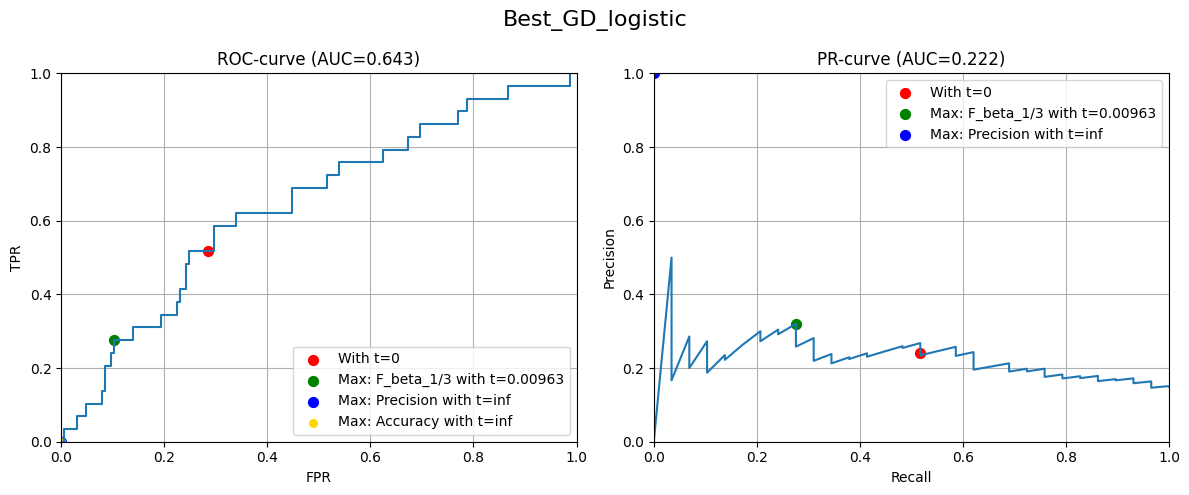

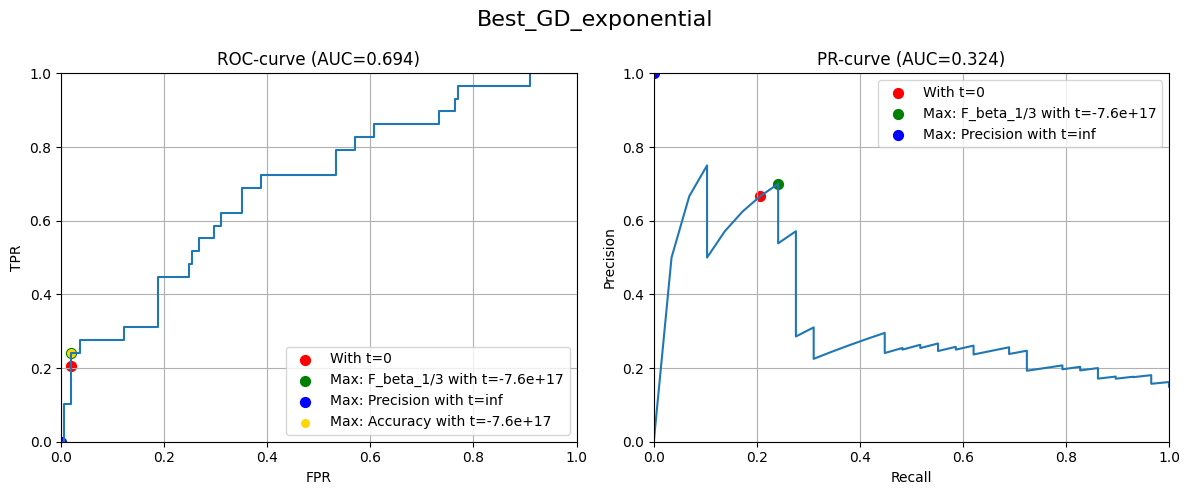

In [57]:
tau_opt = corr_metric_tau(metrics_R_square, obser, count_measures, strategy="max", target="R_square", draw=False)
theta_ridge_1 = ridge_fit(X_train, y_train, tau=tau_opt)

ROC_curve_and_PR_curve(theta_ridge_1,X_val, y_val, title="Ridge")
ROC_curve_and_PR_curve(thetas["Best_SVM"],X_val, y_val, title="Best_GD_SVM")
ROC_curve_and_PR_curve(thetas["Best_logistic"],X_val, y_val, title="Best_GD_logistic")
ROC_curve_and_PR_curve(thetas["Best_exponential"],X_val, y_val, title="Best_GD_exponential")

# Исследуем коэф лин модели

In [58]:
def visualization_thetas(theta, train_df, name="OLS", top_k=60, show_bias=True):
    if show_bias:
        bias_value = theta[0]
    else:
        bias_value = None

    theta_without_b0 = theta[1:]
    max_abs_idx = np.argsort(-np.abs(theta_without_b0))
    top_idx = max_abs_idx[:top_k]
    top_coefs = theta_without_b0[top_idx]
    top_features = train_df.columns[top_idx]

    if show_bias:
        top_coefs = np.concatenate(([bias_value], top_coefs))
        top_features = np.concatenate((["bias"], top_features))

    plt.figure(figsize=(10, 11))
    bars = plt.barh(range(len(top_coefs)), top_coefs, color='skyblue')
    plt.yticks(range(len(top_coefs)), top_features)
    plt.gca().invert_yaxis()
    plt.title(f"Влияние (вес) топ-{top_k} признаков с помощью {name}")
    plt.xlabel("Коэффициент (θ)")
    plt.ylabel("Признак")

    for i, v in enumerate(top_coefs):
        plt.text(v + np.sign(v) * 0.01, i, f"{v:.3f}", va='center',
                 ha='left' if v > 0 else 'right')

    if show_bias:
        bars[0].set_color('orange')

    plt.tight_layout()
    plt.show()


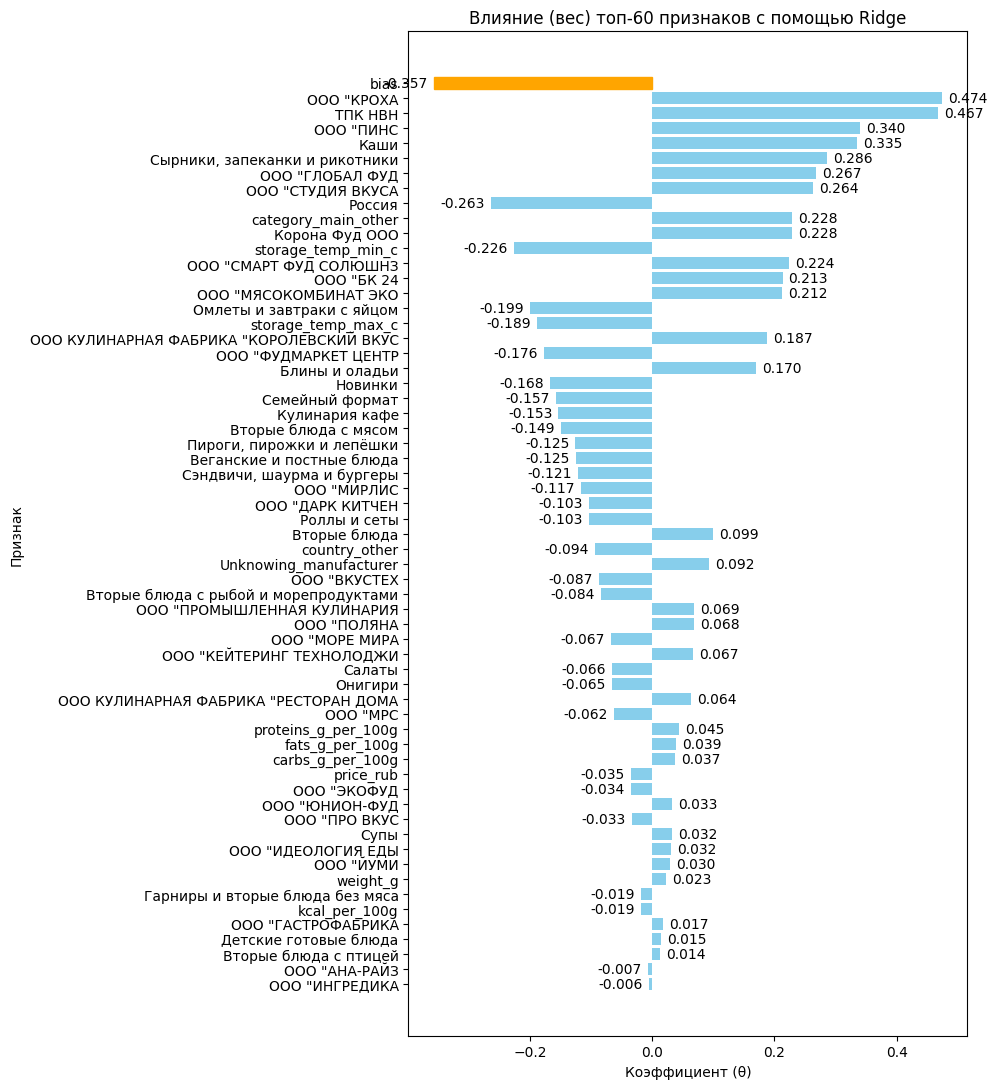

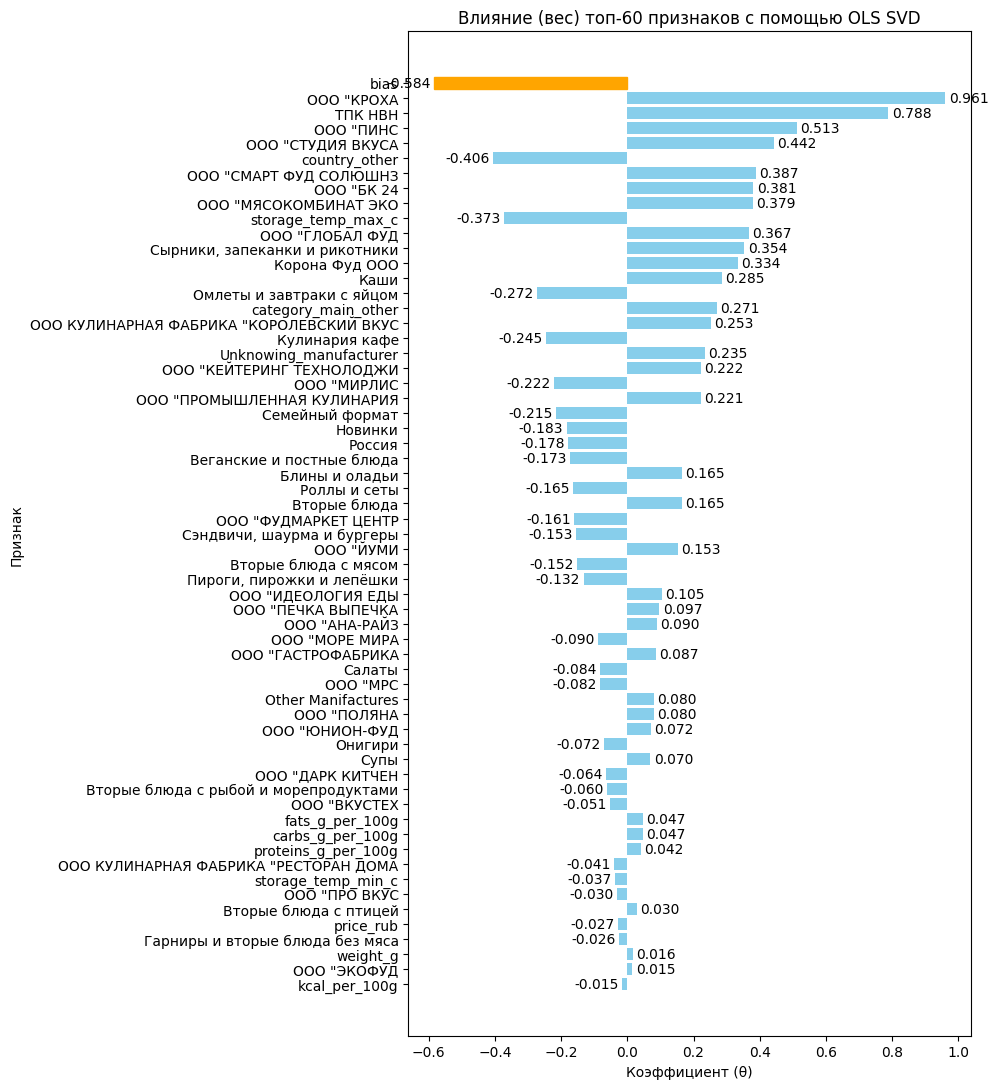

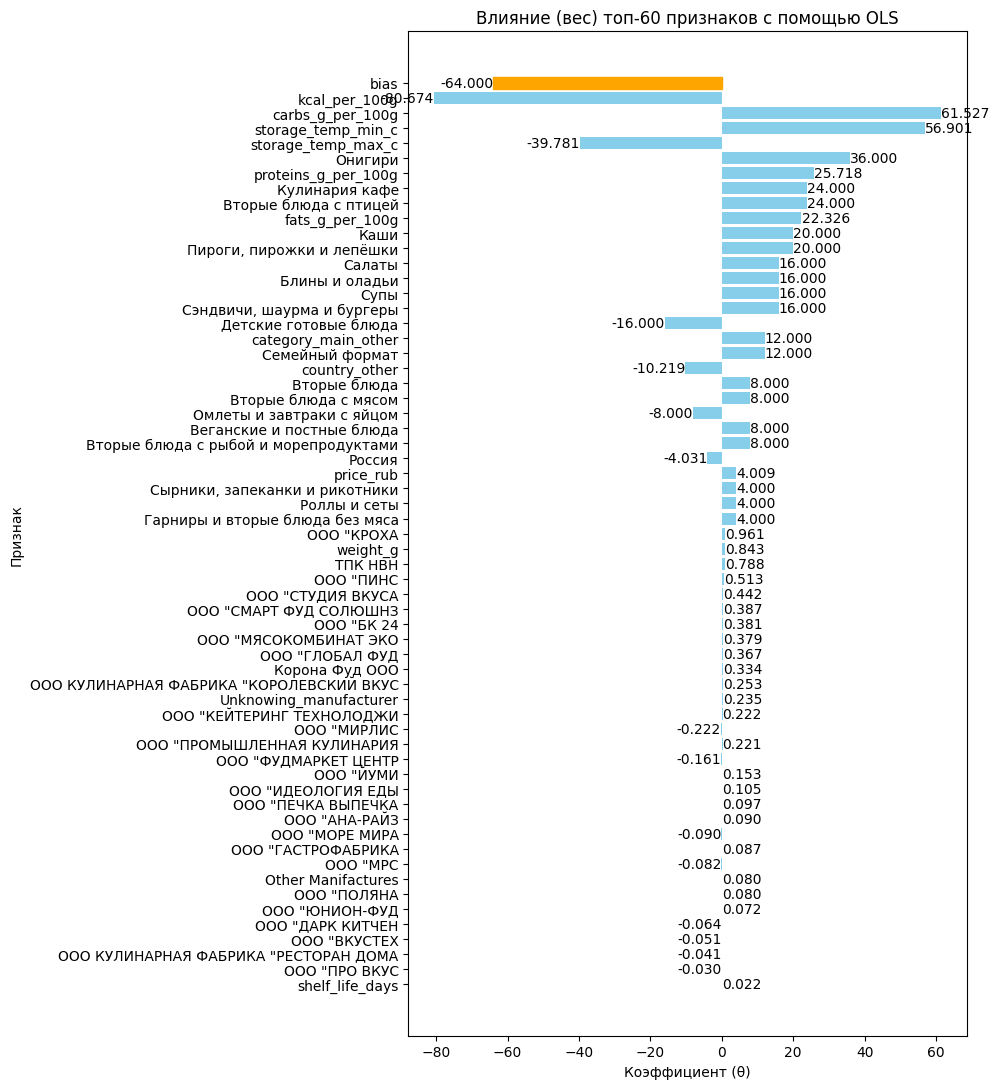

TypeError: only integer scalar arrays can be converted to a scalar index

In [59]:
theta_ols_svd = ols_svd_fit(X_train, y_train)
theta_ols = ols_fit(X_train, y_train)
theta_ridge = ridge_fit(X_train, y_train, tau=6)
theta_ridge_svd = ridge_svd_fit(X_train, y_train, tau=6)
visualization_thetas(theta_ridge, train_df, "Ridge")
visualization_thetas(theta_ols_svd,train_df,  "OLS SVD")
visualization_thetas(theta_ols,train_df,  "OLS")
visualization_thetas(thetas["Best_exponential"],train_df, "Best_exponential")